Jesus Rodrigo Colina Nunez

Student Number: 2017156 

CA 2 Semester 2

#### Imports

In [91]:
import pandas as pd
import numpy as np

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, to_timestamp, date_format, length
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from IPython.display import display


import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import ExponentialSmoothing
from nltk.sentiment.vader import SentimentIntensityAnalyzer



In [2]:
##spark.conf.set("spark.sql.debug.maxToStringFields", 100)

In [3]:
from pyspark.sql import SparkSession


In [4]:
df1 = pd.read_csv('ProjectTweets.csv')

#Load CSV

In [5]:
df1.head()

# here I show how it looks, HERE I am not using Pyspark just yet
# Here I am using pandas

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,1,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,2,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,3,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,4,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,5,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


## Load data set into Spark

In [6]:
df = spark.read.format('csv').option('header', 'false').load('/user1/ProjectTweets.csv')

#I load the data set into Pyspak in order to read it

In [7]:
from pyspark.sql.functions import countDistinct
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

#More imports

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [8]:

df.show()

#Here I show the data set and we see that it does not have columns

+---+----------+--------------------+--------+---------------+--------------------+
|_c0|       _c1|                 _c2|     _c3|            _c4|                 _c5|
+---+----------+--------------------+--------+---------------+--------------------+
|  0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|  1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|  2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|  3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|  4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
|  5|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|  6|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug |
|  7|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|  8|1467811795|Mon Apr 06 22:20:...|NO_QUERY|2Hood4Hollywood|@Tatiana_K nop

In [9]:
df.printSchema()

#Inspect the DataFrame's Structure:  It reveals the blueprint of my data

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)



In [10]:
columns = ["index", "id", "timestamp", "query", "username", "tweet"]
for i in range(len(df.columns)):
    df = df.withColumnRenamed("_c" + str(i), columns[i])
    
#I am going to change the name of the columns

In [97]:
# 2. Save as CSV
df.write.csv("Home/Downloads/CA2_Semestre2/cleaned_data.csv")

In [11]:
df.printSchema()
# This schema provides a valuable overview for understanding the structure and content of my dataset 
# before I start analyzing or manipulating it.

root
 |-- index: string (nullable = true)
 |-- id: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- query: string (nullable = true)
 |-- username: string (nullable = true)
 |-- tweet: string (nullable = true)



In [12]:
df.show(10, truncate=False)

#Here I show the 10 first rows and we noticed that the names has changed

+-----+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|index|id        |timestamp                   |query   |username       |tweet                                                                                                              |
+-----+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|0    |1467810369|Mon Apr 06 22:19:45 PDT 2009|NO_QUERY|_TheSpecialOne_|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D|
|1    |1467810672|Mon Apr 06 22:19:49 PDT 2009|NO_QUERY|scotthamilton  |is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!    |
|2    |1467810917|Mon Apr 06 22:19:53 PDT 2009|NO_QUERY

In [13]:

# Get summary statistics count, mean
df.describe().show()

24/05/23 20:37:32 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+--------------------+--------------------+--------+--------------------+--------------------+
|summary|             index|                  id|           timestamp|   query|            username|               tweet|
+-------+------------------+--------------------+--------------------+--------+--------------------+--------------------+
|  count|           1600000|             1600000|             1600000| 1600000|             1600000|             1600000|
|   mean|          799999.5|1.9988175522956276E9|                null|    null| 4.325887521835714E9|                null|
| stddev|461880.35968924535|1.9357607362268043E8|                null|    null|5.162733218454890...|                null|
|    min|                 0|          1467810369|Fri Apr 17 20:30:...|NO_QUERY|        000catnap000|                 ...|
|    max|            999999|          2329205794|Wed May 27 07:27:...|NO_QUERY|          zzzzeus111|ï¿½ï¿½ï¿½ï¿½ï¿½ß§...|
+-------+---------------

## EDA

In [14]:
# Add a column for tweet length
df = df.withColumn("tweet_length", length(col("tweet")))

# Analyze tweet lengths (min, max, mean)
df.describe("tweet_length").show()

+-------+-----------------+
|summary|     tweet_length|
+-------+-----------------+
|  count|          1600000|
|   mean|     74.090110625|
| stddev|36.44113790653486|
|    min|                6|
|    max|              374|
+-------+-----------------+



In [22]:
# Create or get SparkSession 
spark = SparkSession.builder.appName("TwitterSentimentEDA").getOrCreate()


24/05/23 22:18:05 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [23]:
# Missing Values
print("\nMissing Values:")
df.select([(count(col(c).isNull())).alias(c) for c in df.columns]).show()


#There is no missing values



Missing Values:


+-------+-------+---------+-------+--------+-------+------------+------------+
|  index|     id|timestamp|  query|username|  tweet|tweet_length|timestamp_dt|
+-------+-------+---------+-------+--------+-------+------------+------------+
|1600000|1600000|  1600000|1600000| 1600000|1600000|     1600000|     1600000|
+-------+-------+---------+-------+--------+-------+------------+------------+



In [26]:
# Convert timestamp to proper datetime format
df = df.withColumn("timestamp", to_timestamp(col("timestamp"), "EEE MMM dd HH:mm:ss zzz yyyy"))

In [27]:
# Extract date and time components for later analysis
df = df.withColumn("date", date_format(col("timestamp"), "yyyy-MM-dd"))
df = df.withColumn("time", date_format(col("timestamp"), "HH:mm:ss"))


In [28]:
# Analyze tweet length
df = df.withColumn("tweet_length", length(col("tweet")))
df.select("tweet", "tweet_length").show(5)


+--------------------+------------+
|               tweet|tweet_length|
+--------------------+------------+
|@switchfoot http:...|         115|
|is upset that he ...|         111|
|@Kenichan I dived...|          89|
|my whole body fee...|          47|
|@nationwideclass ...|         111|
+--------------------+------------+
only showing top 5 rows



In [32]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
from pyspark.sql.functions import to_timestamp


df = df.withColumn("timestamp", to_timestamp(col("timestamp"), "yyyy-MM-dd HH:mm:ss"))


In [33]:
# Group by date and count tweets per day
tweets_per_day = df.groupBy("date").count()
tweets_per_day.show()


+----------+------+
|      date| count|
+----------+------+
|2009-04-18| 16132|
|2009-05-04| 29823|
|2009-05-27| 11619|
|2009-04-19| 33670|
|2009-05-25|   169|
|2009-05-29| 55874|
|2009-04-20| 18447|
|2009-04-07| 20671|
|2009-04-21| 11105|
|2009-05-22| 41206|
|2009-05-03| 25045|
|2009-05-11|  6217|
|2009-05-30|103990|
|2009-05-14| 21526|
|2009-05-12|  4186|
|2009-05-10| 31551|
|2009-05-24|   169|
|2009-05-02| 31096|
|2009-05-18| 44564|
|2009-05-17| 41205|
+----------+------+
only showing top 20 rows



In [34]:
# Group by username and count tweets per user (top 10)
tweets_per_user = df.groupBy("username").count().orderBy(col("count").desc()).limit(10)
tweets_per_user.show()
#The people that habe most tweets

+---------------+-----+
|       username|count|
+---------------+-----+
|       lost_dog|  549|
|        webwoke|  345|
|       tweetpet|  310|
|SallytheShizzle|  281|
|    VioletsCRUK|  279|
|    mcraddictal|  276|
|       tsarnick|  248|
|    what_bugs_u|  246|
|    Karen230683|  238|
|      DarkPiano|  236|
+---------------+-----+



## NLTK vader

In [37]:
#!pip install nltk

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 209.5 kB/s eta 0:00:00 kB/s eta 0:00:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 114.9 kB/s eta 0:00:00MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 143.0 kB/s eta 0:00:00m eta 0:00:010:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 775.1/775.1 kB 1.2 MB/s eta 0:00:00m eta 0:00:010:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 4.3 MB/s eta 0:00:00


In [38]:
import nltk
print(nltk.__version__)

3.8.1


In [35]:
import re
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Function to clean tweets
def clean_tweet(tweet):
    tweet = re.sub(r'http\S+', '', tweet)  # Remove URLs
    tweet = re.sub(r'@\w+', '', tweet)     # Remove mentions
    tweet = re.sub(r'#\w+', '', tweet)     # Remove hashtags
    tweet = re.sub(r'[^A-Za-z\s]', '', tweet)  # Remove special characters
    tweet = tweet.lower()                  # Convert to lowercase
    tweet = tweet.strip()                  # Remove leading/trailing whitespace
    return tweet

# Register UDF
clean_tweet_udf = udf(lambda x: clean_tweet(x), StringType())

# Apply UDF to the DataFrame
df_cleaned = df.withColumn('cleaned_tweet', clean_tweet_udf(df['tweet']))

In [39]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pyspark.sql.functions import col

# Download VADER lexicon
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

# Function to classify sentiment
def get_sentiment(tweet):
    scores = sid.polarity_scores(tweet)
    if scores['compound'] >= 0.05:
        return 'positive'
    elif scores['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Register UDF
get_sentiment_udf = udf(lambda x: get_sentiment(x), StringType())

# Apply UDF to the DataFrame
df_sentiment = df_cleaned.withColumn('sentiment', get_sentiment_udf(df_cleaned['cleaned_tweet']))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/hduser/nltk_data...


## Total result

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy

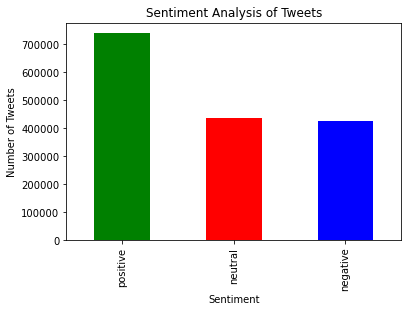

In [40]:
import matplotlib.pyplot as plt

# Convert to Pandas DataFrame
df_pandas = df_sentiment.select('sentiment').toPandas()

# Plot the sentiment distribution
sentiment_counts = df_pandas['sentiment'].value_counts()
sentiment_counts.plot(kind='bar', color=['green', 'red', 'blue'])
plt.title('Sentiment Analysis of Tweets')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.show()

## BY week and HOur

In [41]:
from pyspark.sql.functions import to_date, date_format

# Convert the timestamp to a Spark DateType and extract day of the week and hour
df_with_date = df_sentiment.withColumn('date', to_date('timestamp', 'E MMM dd HH:mm:ss Z yyyy'))
df_with_day = df_with_date.withColumn('day_of_week', date_format('date', 'E'))
df_with_hour = df_with_day.withColumn('hour', date_format('timestamp', 'H'))

# Show the updated DataFrame
df_with_hour.select('timestamp', 'day_of_week', 'hour', 'sentiment').show()


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


+-------------------+-----------+----+---------+
|          timestamp|day_of_week|hour|sentiment|
+-------------------+-----------+----+---------+
|2009-04-07 06:19:45|        Tue|   6| negative|
|2009-04-07 06:19:49|        Tue|   6| negative|
|2009-04-07 06:19:53|        Tue|   6| positive|
|2009-04-07 06:19:57|        Tue|   6| negative|
|2009-04-07 06:19:57|        Tue|   6| negative|
|2009-04-07 06:20:00|        Tue|   6|  neutral|
|2009-04-07 06:20:03|        Tue|   6| positive|
|2009-04-07 06:20:03|        Tue|   6| positive|
|2009-04-07 06:20:05|        Tue|   6|  neutral|
|2009-04-07 06:20:09|        Tue|   6|  neutral|
|2009-04-07 06:20:16|        Tue|   6|  neutral|
|2009-04-07 06:20:17|        Tue|   6|  neutral|
|2009-04-07 06:20:19|        Tue|   6| negative|
|2009-04-07 06:20:19|        Tue|   6| negative|
|2009-04-07 06:20:20|        Tue|   6| positive|
|2009-04-07 06:20:20|        Tue|   6| positive|
|2009-04-07 06:20:22|        Tue|   6| negative|
|2009-04-07 06:20:25

## By day of the week

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy

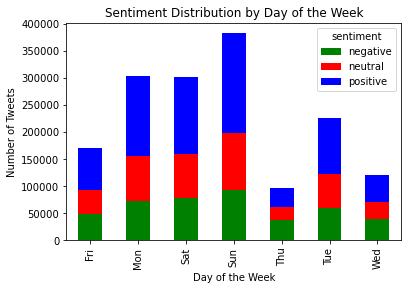

In [42]:
# Convert to Pandas DataFrame
df_pandas_day = df_with_hour.select('day_of_week', 'sentiment').toPandas()

# Plot sentiment distribution by day of the week
sentiment_by_day = df_pandas_day.groupby(['day_of_week', 'sentiment']).size().unstack()
sentiment_by_day.plot(kind='bar', stacked=True, color=['green', 'red', 'blue'])
plt.title('Sentiment Distribution by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Tweets')
plt.show()


### ARIMA, SARIMA AND RNN

In [43]:
from pyspark.sql.functions import when, avg

# Convert sentiment to numerical scores
df_with_scores = df_with_hour.withColumn('sentiment_score', 
                                         when(df_with_hour.sentiment == 'positive', 1).
                                         when(df_with_hour.sentiment == 'negative', -1).
                                         otherwise(0))

# Aggregate sentiment scores by day
df_daily_sentiment = df_with_scores.groupBy('date').agg(avg('sentiment_score').alias('average_sentiment'))

# Convert to Pandas DataFrame for time series analysis
df_daily_sentiment_pd = df_daily_sentiment.orderBy('date').toPandas()

# Set the date as the index
df_daily_sentiment_pd.set_index('date', inplace=True)


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy

In [45]:
##!pip install statsmodels


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 1.6 MB/s eta 0:00:00m eta 0:00:01 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 5.7 MB/s eta 0:00:006.9 MB/s eta 0:00:01


In [46]:
import statsmodels
print(statsmodels.__version__)  # This ptins the installed version, just to check that it is intalled


0.14.2


## ARIMA AND SARIMA MODEL

/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary st

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.13238D-01    |proj g|=  4.20333D+00

At iterate    5    f= -9.08786D-01    |proj g|=  3.84733D-01

At iterate   10    f= -9.10687D-01    |proj g|=  6.48310D-01

At iterate   15    f= -9.19997D-01    |proj g|=  8.09425D-01

At iterate   20    f= -9.97457D-01    |proj g|=  4.66075D-01

At iterate   25    f= -1.00763D+00    |proj g|=  2.74343D-01

At iterate   30    f= -1.00951D+00    |proj g|=  1.15718D-01

At iterate   35    f= -1.00969D+00    |proj g|=  7.11851D-02

At iterate   40    f= -1.00976D+00    |proj g|=  5.01727D-03

At iterate   45    f= -1.00979D+00    |proj g|=  2.46508D-03

At iterate   50    f= -1.00979D+00    |proj g|=  1.54197D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number

/home/hduser/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


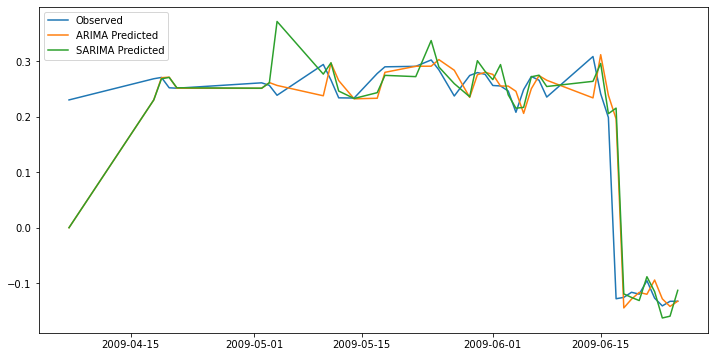

In [47]:
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Fit ARIMA model
arima_model = sm.tsa.ARIMA(df_daily_sentiment_pd['average_sentiment'], order=(1, 1, 1))
arima_result = arima_model.fit()

# Fit SARIMA model
sarima_model = SARIMAX(df_daily_sentiment_pd['average_sentiment'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
sarima_result = sarima_model.fit()

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(df_daily_sentiment_pd['average_sentiment'], label='Observed')
plt.plot(arima_result.predict(start=0, end=len(df_daily_sentiment_pd)-1), label='ARIMA Predicted')
plt.plot(sarima_result.predict(start=0, end=len(df_daily_sentiment_pd)-1), label='SARIMA Predicted')
plt.legend()
plt.show()


## RNN

/home/hduser/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


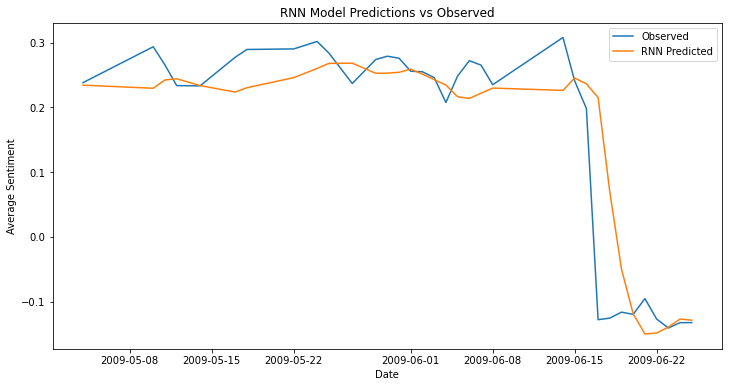

In [53]:

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM




# Prepare data for RNN
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Create sequences
seq_length = 7
data = df_daily_sentiment_pd['average_sentiment'].values
X, y = create_sequences(data, seq_length)

# Reshape for LSTM input
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Define RNN model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X, y, epochs=200, verbose=0)

# Make predictions
y_pred = model.predict(X, verbose=0)

# Convert index to list and slice appropriately for plotting
index = df_daily_sentiment_pd.index[seq_length:].tolist()

# Plot the results for RNN
plt.figure(figsize=(12, 6))
plt.plot(index, y, label='Observed')
plt.plot(index, y_pred, label='RNN Predicted')
plt.legend()
plt.title('RNN Model Predictions vs Observed')
plt.xlabel('Date')
plt.ylabel('Average Sentiment')
plt.show()


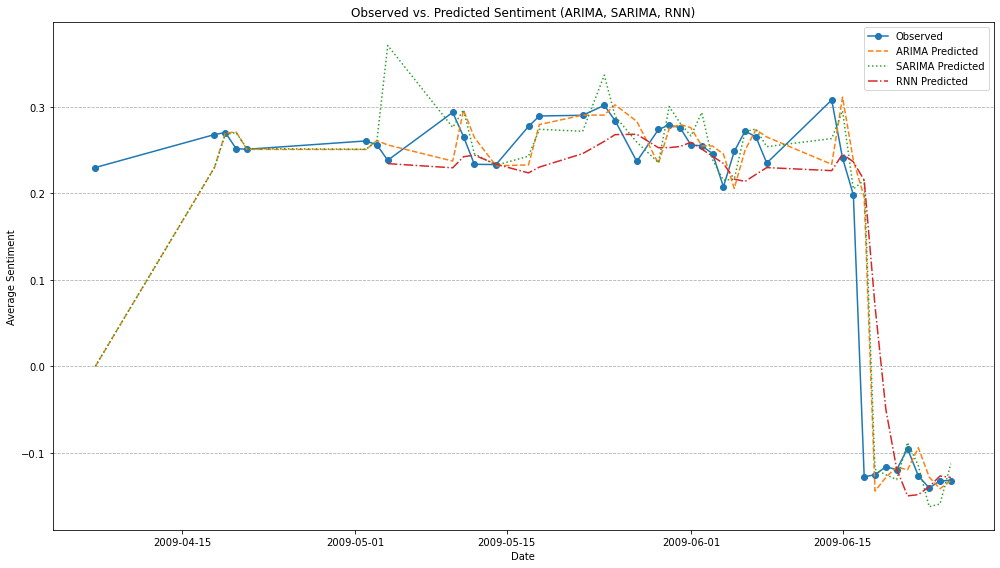

In [54]:
plt.figure(figsize=(14, 8))
plt.plot(df_daily_sentiment_pd['average_sentiment'], label='Observed', marker='o', linestyle='-')

# Plot ARIMA and SARIMA predictions directly on the index (not shifted)
plt.plot(arima_result.predict(start=0, end=len(df_daily_sentiment_pd)-1), label='ARIMA Predicted', linestyle='dashed')
plt.plot(sarima_result.predict(start=0, end=len(df_daily_sentiment_pd)-1), label='SARIMA Predicted', linestyle='dotted')

# Plot RNN predictions on the correct sliced index
plt.plot(index, y_pred, label='RNN Predicted', linestyle='dashdot') 

plt.legend()
plt.title('Observed vs. Predicted Sentiment (ARIMA, SARIMA, RNN)')
plt.xlabel('Date')
plt.ylabel('Average Sentiment')
plt.grid(axis='y', linestyle='--')  
plt.tight_layout()  # Adjust layout to prevent overlapping elements
plt.show()

In [56]:


# Create a new DataFrame to hold results
results_df = pd.DataFrame({
    'Observed': df_daily_sentiment_pd['average_sentiment'],
    'ARIMA Predicted': arima_result.predict(start=0, end=len(df_daily_sentiment_pd)-1),
    'SARIMA Predicted': sarima_result.predict(start=0, end=len(df_daily_sentiment_pd)-1)
})

# Add RNN predictions to the sliced index
results_df = results_df.iloc[seq_length:]  
results_df['RNN Predicted'] = y_pred.flatten() 

# Display the results in a nicely formatted table within the notebook
display(results_df)




,Observed,ARIMA Predicted,SARIMA Predicted,RNN Predicted
date,,,,
2009-05-04,0.238239,0.255963,0.371043,0.234376
2009-05-10,0.293652,0.237337,0.276328,0.229559
2009-05-11,0.265562,0.296186,0.296631,0.242361
2009-05-12,0.233636,0.264692,0.245831,0.244205
2009-05-14,0.233253,0.231898,0.232480,0.233723
2009-05-17,0.277442,0.232887,0.242952,0.223655
2009-05-18,0.289449,0.279534,0.274083,0.230361
2009-05-22,0.290322,0.290455,0.271787,0.245943
2009-05-24,0.301775,0.290565,0.336687,0.260149


In [58]:
#!pip install pandas numpy matplotlib seaborn statsmodels vaderSentiment


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 70.5 kB/s eta 0:00:000:00:01m eta 0:00:01


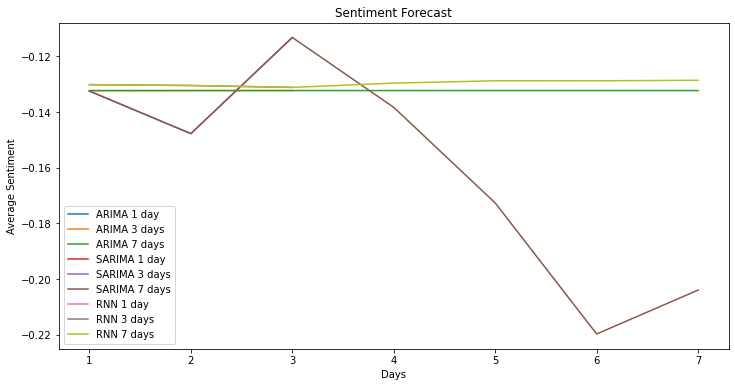

In [72]:
# Convert the forecasted values to numpy arrays
arima_forecast_1d = arima_forecast_1d.values
arima_forecast_3d = arima_forecast_3d.values
arima_forecast_7d = arima_forecast_7d.values

sarima_forecast_1d = sarima_forecast_1d.values
sarima_forecast_3d = sarima_forecast_3d.values
sarima_forecast_7d = sarima_forecast_7d.values

# Now you can plot these values
plt.figure(figsize=(12, 6))

# ARIMA
plt.plot(range(1, 2), arima_forecast_1d, label='ARIMA 1 day')
plt.plot(range(1, 4), arima_forecast_3d, label='ARIMA 3 days')
plt.plot(range(1, 8), arima_forecast_7d, label='ARIMA 7 days')

# SARIMA
plt.plot(range(1, 2), sarima_forecast_1d, label='SARIMA 1 day')
plt.plot(range(1, 4), sarima_forecast_3d, label='SARIMA 3 days')
plt.plot(range(1, 8), sarima_forecast_7d, label='SARIMA 7 days')

# RNN
plt.plot(range(1, 2), rnn_forecast_1d, label='RNN 1 day')
plt.plot(range(1, 4), rnn_forecast_3d, label='RNN 3 days')
plt.plot(range(1, 8), rnn_forecast_7d, label='RNN 7 days')

plt.legend()
plt.title('Sentiment Forecast')
plt.xlabel('Days')
plt.ylabel('Average Sentiment')
plt.show()


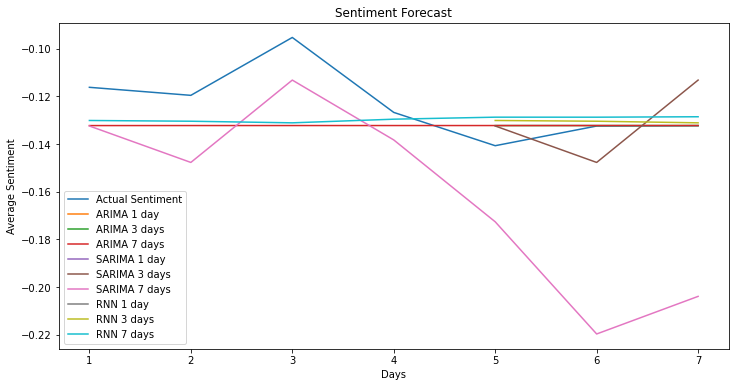

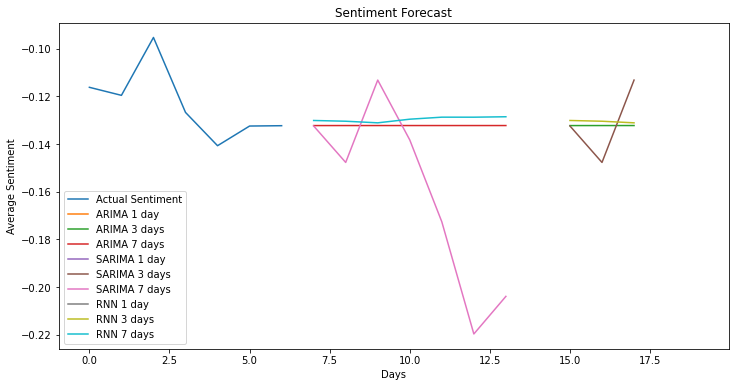

In [76]:
# Now you can plot these values
plt.figure(figsize=(12, 6))

# Actual sentiment
plt.plot(range(len(actual_sentiment)-7, len(actual_sentiment)), actual_sentiment[-7:], label='Actual Sentiment')

# ARIMA
plt.plot(range(len(actual_sentiment), len(actual_sentiment)+len(arima_forecast_1d)), arima_forecast_1d, label='ARIMA 1 day')
plt.plot(range(len(actual_sentiment), len(actual_sentiment)+len(arima_forecast_3d)), arima_forecast_3d, label='ARIMA 3 days')
plt.plot(range(len(actual_sentiment), len(actual_sentiment)+len(arima_forecast_7d)), arima_forecast_7d, label='ARIMA 7 days')

# SARIMA
plt.plot(range(len(actual_sentiment), len(actual_sentiment)+len(sarima_forecast_1d)), sarima_forecast_1d, label='SARIMA 1 day')
plt.plot(range(len(actual_sentiment), len(actual_sentiment)+len(sarima_forecast_3d)), sarima_forecast_3d, label='SARIMA 3 days')
plt.plot(range(len(actual_sentiment), len(actual_sentiment)+len(sarima_forecast_7d)), sarima_forecast_7d, label='SARIMA 7 days')

# RNN
plt.plot(range(len(actual_sentiment), len(actual_sentiment)+len(rnn_forecast_1d)), rnn_forecast_1d, label='RNN 1 day')
plt.plot(range(len(actual_sentiment), len(actual_sentiment)+len(rnn_forecast_3d)), rnn_forecast_3d, label='RNN 3 days')
plt.plot(range(len(actual_sentiment), len(actual_sentiment)+len(rnn_forecast_7d)), rnn_forecast_7d, label='RNN 7 days')

plt.legend()
plt.title('Sentiment Forecast')
plt.xlabel('Days')
plt.ylabel('Average Sentiment')
plt.show()


In [90]:
#!pip install dash


## Interactive dashboard

In [89]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.graph_objs as go

# Initialize the app
app = dash.Dash(__name__)

# Define the layout
app.layout = html.Div([
    html.H1('Sentiment Analysis Dashboard'),
    dcc.Graph(
        id='sentiment-graph',
        figure={
            'data': [
                go.Scatter(x=list(range(len(actual_sentiment)-7, len(actual_sentiment))), y=actual_sentiment[-7:], mode='lines', name='Actual Sentiment'),
                go.Scatter(x=list(range(len(actual_sentiment), len(actual_sentiment)+len(arima_forecast_1d))), y=arima_forecast_1d, mode='lines', name='ARIMA 1 day'),
                go.Scatter(x=list(range(len(actual_sentiment), len(actual_sentiment)+len(arima_forecast_3d))), y=arima_forecast_3d, mode='lines', name='ARIMA 3 days'),
                go.Scatter(x=list(range(len(actual_sentiment), len(actual_sentiment)+len(arima_forecast_7d))), y=arima_forecast_7d, mode='lines', name='ARIMA 7 days'),
                go.Scatter(x=list(range(len(actual_sentiment), len(actual_sentiment)+len(sarima_forecast_1d))), y=sarima_forecast_1d, mode='lines', name='SARIMA 1 day'),
                go.Scatter(x=list(range(len(actual_sentiment), len(actual_sentiment)+len(sarima_forecast_3d))), y=sarima_forecast_3d, mode='lines', name='SARIMA 3 days'),
                go.Scatter(x=list(range(len(actual_sentiment), len(actual_sentiment)+len(sarima_forecast_7d))), y=sarima_forecast_7d, mode='lines', name='SARIMA 7 days'),
                go.Scatter(x=list(range(len(actual_sentiment), len(actual_sentiment)+len(rnn_forecast_1d))), y=rnn_forecast_1d, mode='lines', name='RNN 1 day'),
                go.Scatter(x=list(range(len(actual_sentiment), len(actual_sentiment)+len(rnn_forecast_3d))), y=rnn_forecast_3d, mode='lines', name='RNN 3 days'),
                go.Scatter(x=list(range(len(actual_sentiment), len(actual_sentiment)+len(rnn_forecast_7d))), y=rnn_forecast_7d, mode='lines', name='RNN 7 days'),
            ],
            'layout': go.Layout(
                title='Sentiment Over Time',
                xaxis=dict(title='Days'),
                yaxis=dict(title='Average Sentiment')
            )
        }
    )
])

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)


### MontoDB Connection

In [26]:
#pip install pymongo==3.12.3  

# I had to install this version because The newest verion gave me lots of errors

In [27]:
from pymongo import MongoClient

# My MongoDB connection details
client = MongoClient("mongodb://localhost:27017/") 
db = client["ProjectTweets"]  # My data base name

In [28]:
import pandas as pd

df5 = pd.read_csv('ProjectTweets.csv')  

In [29]:
data = df5.to_dict(orient='records')

In [30]:
collection = db["my_collection"] 

In [31]:
import pandas as pd
from pymongo import MongoClient

# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["my_database"]
collection = db["my_collection"]

# Read CSV file
df = pd.read_csv('ProjectTweets.csv')

# Convert to dictionaries
data = df.to_dict(orient='records')

# Insert into MongoDB
collection.insert_many(data)

print("Data uploaded successfully!")


Data uploaded successfully!


In [32]:
# Retrieve all documents
all_documents = collection.find()

# Display the first few rows
for doc in all_documents.limit(5):
    print(doc)
    
#Now we can see that mongoDB is working fine and is able to read the file.

{'_id': ObjectId('664eada25c8a34c9afff91d9'), '0': 1, '1467810369': 1467810672, 'Mon Apr 06 22:19:45 PDT 2009': 'Mon Apr 06 22:19:49 PDT 2009', 'NO_QUERY': 'NO_QUERY', '_TheSpecialOne_': 'scotthamilton', "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D": "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"}
{'_id': ObjectId('664eada25c8a34c9afff91da'), '0': 2, '1467810369': 1467810917, 'Mon Apr 06 22:19:45 PDT 2009': 'Mon Apr 06 22:19:53 PDT 2009', 'NO_QUERY': 'NO_QUERY', '_TheSpecialOne_': 'mattycus', "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D": '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds'}
{'_id': ObjectId('664eada25c8a34c9afff91db'), '0': 3, '1467810369': 1467811184, 'Mon Apr 06 22:19:45 PDT 2009': 'Mon Apr 06 22:19:57 PDT 2009', 'NO_QUE

24/05/23 19:03:21 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 246844 ms exceeds timeout 120000 ms
24/05/23 19:03:21 WARN SparkContext: Killing executors is not supported by current scheduler.
24/05/23 19:03:26 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.B

24/05/23 19:03:36 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

24/05/23 19:03:46 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/05/23 19:03:56 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

24/05/23 19:04:06 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/05/23 19:04:16 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

24/05/23 19:04:26 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/05/23 19:04:36 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

24/05/23 19:04:46 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

24/05/23 19:04:56 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

24/05/23 19:05:06 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/05/23 19:05:16 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/05/23 19:05:26 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/05/23 19:05:36 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

24/05/23 19:05:56 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/05/23 19:06:06 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/05/23 19:06:26 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/05/23 19:06:46 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/05/23 19:06:56 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/05/23 19:07:06 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/05/23 19:07:16 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/05/23 19:07:26 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

24/05/23 19:07:36 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

24/05/23 19:07:46 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

24/05/23 19:07:56 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/05/23 19:08:06 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

24/05/23 19:08:16 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

24/05/23 19:08:26 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

24/05/23 19:08:36 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

24/05/23 19:08:46 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/05/23 19:08:56 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/05/23 19:09:06 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/05/23 19:09:16 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

24/05/23 19:09:26 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/05/23 19:09:36 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/05/23 19:09:46 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/05/23 19:09:56 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/05/23 19:10:06 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

24/05/23 19:10:16 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/05/23 19:10:26 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/05/23 19:10:36 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

24/05/23 19:10:46 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

24/05/23 19:10:56 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

24/05/23 19:11:06 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

24/05/23 19:11:16 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/05/23 19:11:26 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

24/05/23 19:11:36 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/05/23 19:11:46 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/05/23 19:11:56 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

24/05/23 19:12:06 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/05/23 19:12:16 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/05/23 19:12:26 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/05/23 19:12:36 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/05/23 19:12:46 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/05/23 19:12:56 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/05/23 19:13:06 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/05/23 19:13:16 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j